In [2]:
from __future__ import absolute_import, division, print_function
import os
import matplotlib.pyplot as plt
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

In [3]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)

print('Local copy of the dataset file:{}'.format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step


Local copy of the dataset file:C:\Users\Administrator\.keras\datasets\iris_training.csv


In [4]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [5]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [6]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [7]:
features, labels = next(iter(train_dataset))

In [9]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')
plt.show()
plt.xlabel("Petal length")
plt.ylabel("Sepal length")

TypeError: object of type 'tensorflow.python.framework.ops.EagerTensor' has no len()

In [10]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels
train_dataset = train_dataset.map(pack_features_vector)

In [20]:
features, labels = next(iter(train_dataset))

print(features[:5])
print(labels[:5])

tf.Tensor(
[[7.7 3.  6.1 2.3]
 [5.2 3.4 1.4 0.2]
 [6.8 2.8 4.8 1.4]
 [6.  3.  4.8 1.8]
 [6.3 3.3 4.7 1.6]], shape=(5, 4), dtype=float32)
tf.Tensor([2 0 1 2 1], shape=(5,), dtype=int32)


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

In [13]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=189, shape=(5, 3), dtype=float32, numpy=
array([[-0.9038358 , -0.43131614, -0.84276235],
       [-1.1417366 , -0.64117897, -1.046058  ],
       [-1.293345  , -0.7263195 , -1.1849614 ],
       [-1.2702454 , -0.7133472 , -1.1637976 ],
       [-0.78131133, -0.26786238, -0.74871075]], dtype=float32)>

In [14]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=195, shape=(5, 3), dtype=float32, numpy=
array([[0.27270192, 0.43742225, 0.28987586],
       [0.26666337, 0.4398988 , 0.29343778],
       [0.25789878, 0.45467946, 0.28742176],
       [0.25923052, 0.45242226, 0.28834727],
       [0.2699651 , 0.45112374, 0.27891117]], dtype=float32)>

In [15]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [0 1 2 2 0 2 0 2 1 0 1 0 1 0 0 2 0 0 1 0 1 0 1 1 2 0 2 2 1 2 0 0]


In [17]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

In [18]:
l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.1444014310836792


In [19]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()

In [22]:
loss_value, grads = grad(model, features, labels)
print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)
print("Step: {},Loss: {}".format(global_step.numpy(),
                                 loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.1242667436599731
Step: 1,Loss: 1.1187150478363037


In [23]:
# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step)

        # Track progress
        epoch_loss_avg(loss_value)  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))

Epoch 000: Loss: 1.120, Accuracy: 30.000%


Epoch 050: Loss: 0.885, Accuracy: 67.500%


Epoch 100: Loss: 0.516, Accuracy: 70.000%


Epoch 150: Loss: 0.453, Accuracy: 70.000%


Epoch 200: Loss: 0.421, Accuracy: 70.000%


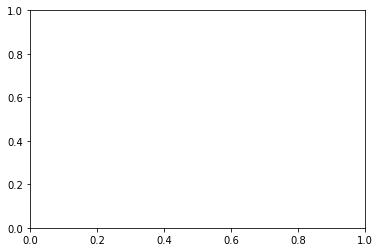

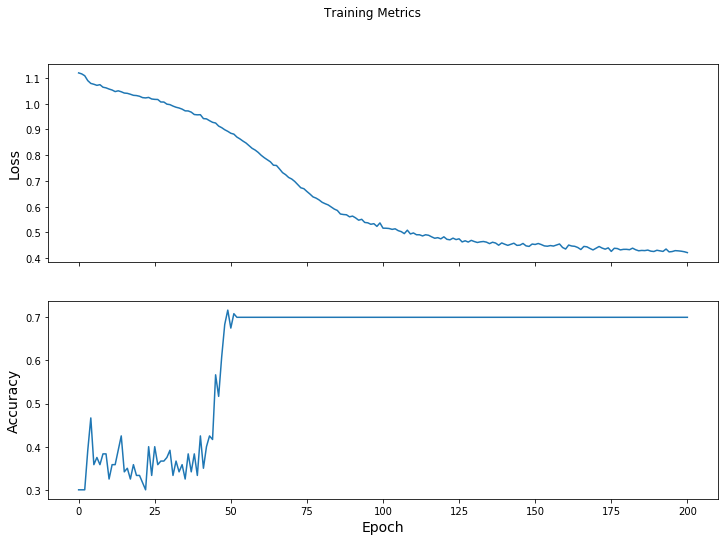

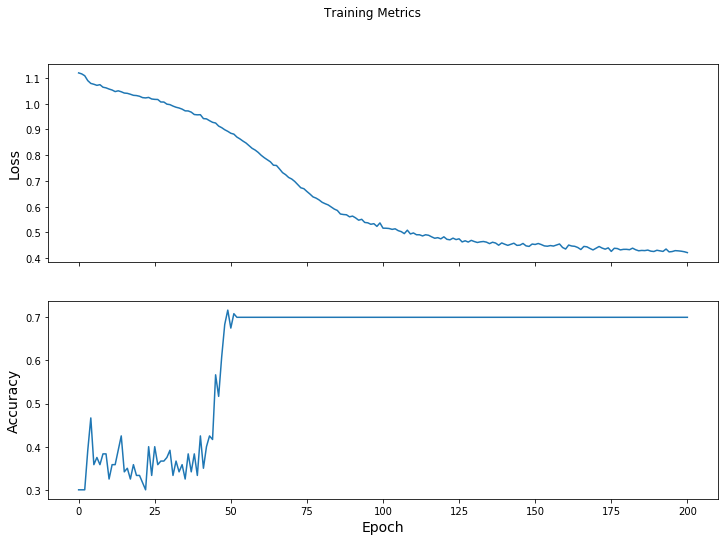

In [25]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [26]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [27]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [28]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 53.333%


In [29]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=116824, shape=(30, 2), dtype=int32, numpy=
array([[1, 2],
       [2, 2],
       [0, 0],
       [1, 2],
       [1, 2],
       [1, 2],
       [0, 0],
       [2, 2],
       [1, 2],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 2],
       [1, 2],
       [0, 0],
       [1, 2],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 2],
       [2, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [0, 0],
       [1, 2],
       [2, 2],
       [1, 2]])>

In [30]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5, ],
    [5.9, 3.0, 4.2, 1.5, ],
    [6.9, 3.1, 5.4, 2.1]
])

In [31]:
predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100 * p))

Example 0 prediction: Iris setosa (97.8%)
Example 1 prediction: Iris virginica (53.7%)
Example 2 prediction: Iris virginica (62.0%)
